# Apartado 3  Práctica 3  
# Transferencia de modelos y ajste fino con ResNet50 para la base de datos Caltech-UCSD  

Autora: Blanca Cano Camarero 
  
Trabajaremos con el conjunto de datos Caltech-UCSD. Este conjunto de datos se compone de 6033 imágenes de 200 especies de pájaros.
Tiene, por tanto, 200 clases, con 3000 imágenes en el conjunto de entrenamiento y 3033 en el de prueba. De nuevo, se dejará un 10% del conjunto de entrenamiento para validación. Para leer el conjunto de datos usar las funciones dadas.
Usaremos el modelo de red ResNet50 ya pre-entrenada con ImageNet y que está disponible en Keras. 

## Ejercicio 1 

1.- Usar ResNet50 como un extractor de características para los datos de Caltech-UCSD disponible en http://www.vision.caltech.edu/visipedia/CUB-200.html Para ello eliminaremos al menos las dos últimas capas del modelo descargado, añadiremos algunas capas de cálculo adicional y la capa de salida. En concreto realizar los siguientes experimentos:


### A a) Adaptar el modelo ResNet a los datos de Caltech-UCSD y estimar su desempeño con esos datos  



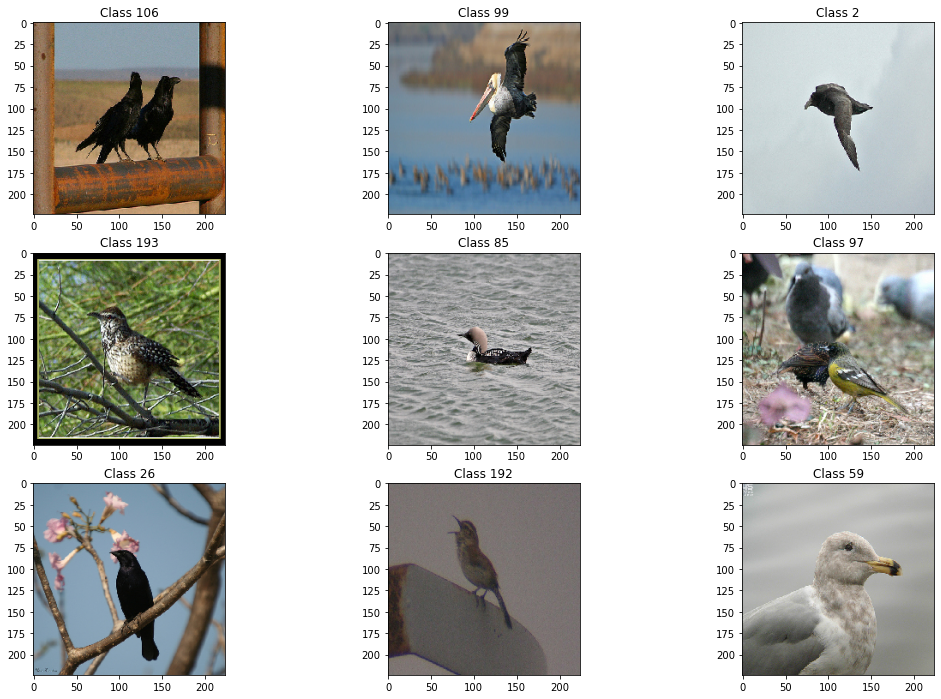

2021-12-24 14:37:49.301178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-24 14:37:49.301353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2021-12-24 14:37:50.872276: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-24 14:37:51.032640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 3s 10ms/step


2021-12-24 14:38:51.822776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 3s 10ms/step
------------------------------------------------------------
[Info 1] Tamaños de los vectores de características de resnet50 SIN FC:
Tamaño del vector de características train : (2700, 2048)
Tamaño del vector de características validation : (300, 2048)
Tamaño del vector de características test : (3033, 2048)

[Info 1] Tamaños de los vectores de características de resnet50 CON FC:
Tamaño del vector de características train : (2700, 1000)
Tamaño del vector de características validation : (300, 1000)
Tamaño del vector de características test : (3033, 1000)


In [1]:
# Tarda un minuto la ejecución 
#########################################################################
################### OBTENER LA BASE DE DATOS ############################
#########################################################################

# Descargar las imágenes de http://www.vision.caltech.edu/visipedia/CUB-200.html
# Descomprimir el fichero.
# Descargar también el fichero list.tar.gz, descomprimirlo y guardar los ficheros
# test.txt y train.txt dentro de la carpeta de imágenes anterior. Estos 
# dos ficheros contienen la partición en train y test del conjunto de datos.

##### EN CASO DE USAR COLABORATORY
# Sube tanto las imágenes como los ficheros text.txt y train.txt a tu drive.
# Después, ejecuta esta celda y sigue las instrucciones para montar 
# tu drive en colaboratory.
#from google.colab import drive
#drive.mount('/content/drive')

#########################################################################
################ CARGAR LAS LIBRERÍAS NECESARIAS ########################
#########################################################################

# Terminar de rellenar este bloque con lo que vaya haciendo falta

# Importar librerías necesarias
import tensorflow as tf
import numpy as np
import keras
import tensorflow.keras.utils as np_utils
from keras.preprocessing.image  import load_img,img_to_array, ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import ReLU, LeakyReLU
# Importar el modelo ResNet50 y su respectiva función de preprocesamiento,
# que es necesario pasarle a las imágenes para usar este modelo
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import matplotlib.pyplot as plt
# Importar el optimizador a usar
from tensorflow.keras.optimizers import SGD,Adam

# Importar la función de pérdida a usar
from tensorflow.keras.losses import categorical_crossentropy

from sklearn.model_selection import train_test_split
#########################################################################
################## FUNCIÓN PARA LEER LAS IMÁGENES #######################
#########################################################################

# Dado un fichero train.txt o test.txt y el path donde se encuentran los
# ficheros y las imágenes, esta función lee las imágenes
# especificadas en ese fichero y devuelve las imágenes en un vector y 
# sus clases en otro.

def leerImagenes(vec_imagenes, path):
  clases = np.array([img.split('/')[0] for img in vec_imagenes])
  imagenes = np.array([img_to_array(load_img(path + "/" + img, 
                                             target_size = (224, 224))) 
                       for img in vec_imagenes])
  return imagenes, clases

#########################################################################
############# FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS ##################
#########################################################################

# Usando la función anterior, y dado el path donde se encuentran las
# imágenes y los archivos "train.txt" y "test.txt", devuelve las 
# imágenes y las clases de train y test para usarlas con keras
# directamente.

def cargarDatos(path_list, path_images):
  '''path list : los archivos de train.txt y test.txt 
    path_images: es dónde se encuentran las imágenes

  si ambas están en la misma carpeta entontes path_list debe hacerse path_images
  '''
  # Cargamos los ficheros
  train_images = np.loadtxt(path_list + "/train.txt", dtype = str)
  test_images = np.loadtxt(path_list  + "/test.txt", dtype = str)
  
  # Leemos las imágenes con la función anterior
  train, train_clases = leerImagenes(train_images, path_images)
  test, test_clases = leerImagenes(test_images, path_images)
  
  # Pasamos los vectores de las clases a matrices 
  # Para ello, primero pasamos las clases a números enteros
  clases_posibles = np.unique(np.copy(train_clases))
  for i in range(len(clases_posibles)):
    train_clases[train_clases == clases_posibles[i]] = i
    test_clases[test_clases == clases_posibles[i]] = i

  # Después, usamos la función to_categorical()
  train_clases = np_utils.to_categorical(train_clases, 200)
  test_clases = np_utils.to_categorical(test_clases, 200)
  
  # Barajar los datos
  train_perm = np.random.permutation(len(train))
  train = train[train_perm]
  train_clases = train_clases[train_perm]

  test_perm = np.random.permutation(len(test))
  test = test[test_perm]
  test_clases = test_clases[test_perm]

  '''Esto causa errores en el entrenamiento
  # normalizazamos los valores
  train = train.astype('float32')
  test = test.astype('float32')
  train /= 255
  test /= 255
  ''' 
  return train, train_clases, test, test_clases

#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy


#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución de la función
# de pérdida en el conjunto de train y en el de validación, y otra
# con la evolución del accuracy en el conjunto de train y en el de
# validación. Es necesario pasarle como parámetro el historial
# del entrenamiento del modelo (lo que devuelven las funciones
# fit() y fit_generator()).

def mostrarEvolucion(hist, titulo1=None, titulo2=None):
  '''
  Esta función pinta dos gráficas, una con la evolución de la función
 de pérdida en el conjunto de train y en el de validación, y otra
 con la evolución del accuracy en el conjunto de train y en el de
 validación. Es necesario pasarle como parámetro el historial
del entrenamiento del modelo (lo que devuelven las funciones
 fit() y fit_generator()).

  '''
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  if(titulo1 != None):
    plt.title(titulo1)
  plt.show()
  
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  if(titulo2 != None):
    plt.title(titulo2)
  plt.show()
  

"""## Usar ResNet50 preentrenada en ImageNet como un extractor de características"""

# Definir un objeto de la clase ImageDataGenerator para train y otro para test
# con sus respectivos argumentos.
# A completar

PATH_LIST = 'lists'
PATH_IMAGES = 'images'
x_train, y_train, x_test, y_test = cargarDatos(PATH_LIST, PATH_IMAGES)
SEED = 1

x_train_y_validacion = np.copy(x_train)
y_train_y_validacion = np.copy(y_train)

## vamos a tomar el 10% de los datos de entrenamiento para validación 
porcentaje_validacion = 0.1
# utilizamos la función de sklearn que nos permite separar datos de entrenamiento de los de test    
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train,
    y_train,
    test_size= porcentaje_validacion,
    stratify = y_train,
    shuffle = True,
    random_state=SEED
)

#VISUALIZAMOS ALGUNAS DE LAS IMÁGENES DEL DATASET
number_images_per_row = 3
result = np.where(y_train == 1)
# aquí marca el errro 
fig = plt.figure()
for i in range(number_images_per_row*number_images_per_row):
  label = 'Class {}'.format(result[1][i])
  plt.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
  plt.imshow((x_train[i]/255).squeeze(), cmap='gray',vmin=0,vmax=1)

fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)
plt.show()


tam_batch = 33
epocas = 10
porcentaje_val = 0.1
optimizador = SGD()

generador_datos_resnet50 = ImageDataGenerator(preprocessing_function = preprocess_input)

# Definir el modelo ResNet50 (preentrenado en ImageNet y sin la última capa).
modelo_resnet50_sin_FC = ResNet50(
  include_top = False, # No incluimos la capa FC, ya que queremos entrenarla
  weights = "imagenet", # pesos entrenados de imagenenet
  pooling = "avg")
modelo_resnet50_con_FC = ResNet50(
  include_top = True, # Incluímos la capa FC
  weights = "imagenet", # pesos entrenados de imagenenet
  pooling = "avg")

modelo_resnet50_sin_FC.trainable = False  # congelamos el modelo para que no se pueda entrenar 
modelo_resnet50_con_FC.trainable = False  # congelamos el modelo para que no se pueda entrenar 
# Extraer las características las imágenes con el modelo anterior.
# A completar

# EXTRAEMOS CARACTERÍSTICAS SIN FC
caracteristicas_train_sin_FC = modelo_resnet50_sin_FC.predict(generador_datos_resnet50.flow(x_train, batch_size = 1, shuffle = False), steps = len(x_train), verbose = 1)
# extraemos las caracteristicas de test
caracteristicas_test_sin_FC  = modelo_resnet50_sin_FC.predict(generador_datos_resnet50.flow(x_test, batch_size = 1, shuffle = False), steps = len(x_test), verbose = 1)
caracteristicas_validation_sin_FC  = modelo_resnet50_sin_FC.predict(generador_datos_resnet50.flow(x_validation, batch_size = 1, shuffle = False), steps = len(x_validation), verbose = 1)
# CARACTERÍSTICAS CON FC sin ajustar el número de clases 
caracteristicas_train_con_FC = modelo_resnet50_con_FC.predict(generador_datos_resnet50.flow(x_train, batch_size = 1, shuffle = False), steps = len(x_train), verbose = 1)
caracteristicas_test_con_FC = modelo_resnet50_con_FC.predict(generador_datos_resnet50.flow(x_test, batch_size = 1, shuffle = False), steps = len(x_test), verbose = 1)
caracteristicas_validation_con_FC = modelo_resnet50_con_FC.predict(generador_datos_resnet50.flow(x_validation, batch_size = 1, shuffle = False), steps = len(x_validation), verbose = 1)

print('---'*20)
# Tamaño características sin FC
print('[Info 1] Tamaños de los vectores de características de resnet50 SIN FC:')
print('Tamaño del vector de características train :', caracteristicas_train_sin_FC.shape)
print('Tamaño del vector de características validation :', caracteristicas_validation_sin_FC.shape)
print('Tamaño del vector de características test :', caracteristicas_test_sin_FC.shape)
# Tamaño características con FC sin adaptar número de clases 
print('\n[Info 1] Tamaños de los vectores de características de resnet50 CON FC:')
print('Tamaño del vector de características train :', caracteristicas_train_con_FC.shape)
print('Tamaño del vector de características validation :', caracteristicas_validation_con_FC.shape)
print('Tamaño del vector de características test :', caracteristicas_test_con_FC.shape)


### Explicación sobre cómo se ha implementado el apartado A (a)

Consultado la bibliografía oficial de keras sobre ResNet [1] y de ahí se han deducido los import necesarios: 

- Importar el modelo concreto`. 
- Importar la función específica de preprocesamiento de la entrada que depende del modelo, para este modelo concreto `tf.keras.applications.resnet.preprocess_input` (Debemos de denotar que transforma las imágenes de entrada de RGB a BGR y después zero-center each color channel with respect to the ImageNet dataset, without scaling.
Todo esto se refleja en el import `from keras.applications.resnet50 import ResNet50, preprocess_input`  

Lo que hacemos en esta parte es extraer características de la entrada es decir un vector que nos de información. 

En ningún momento se hace referencia a cuál va a ser la estructura a entrenar para la clasificación , como mínimo debería de tener una capa totalmente conectada con 200 neuronas, el número de clases que hay en nuestro problema. 
Necesario añadir al final del modelo una capa fully connected con tantas neuronas como clases tenga el problema y activación softmax. 

TODO
La arquitectura propia de la resnet50 [2] tan solo utiliza un capa FC tras hacer un average pool, que clasifica a 1000 clases, tomaremos entonces este diseño.
Pero deberemos adaptar esas 10000 clases a las 200 de nuestro modelo, eso es posible gracias al argumento `classes` con `include_top = True`. 

También experimentaremos añadiendo dos capas FC  **segunda implementación**, ya que a priori nos proporcionaría mayor variabilidad. 

Además observando *[info 1]* nos damos cuenta que el número de características que se extraen de la red son: 2048. Por lo que se puede definir un input de 2048. 


*Tabla 0:* Tamaño de las características extraídas   

Conjunto de datos | Sin eliminar últimas capas de la ResNet50 | Eliminando últimas capas  
:-: | :-: | :-:  
train  | (2700, 1000) | (2700, 2048)  
validación |  (300, 1000)|  (300, 2048)  
Test | (3033, 1000)|  (3033, 2048)

In [3]:
# Hemos observado 
NUMERO_CARACTERISTICAS = 2048
INPUT = (NUMERO_CARACTERISTICAS,)
NUM_CLASES = 200
epocas = 25
NUM_CLASES_RESNET = 1000

def CompilarModelo(model):
    model.compile(loss=categorical_crossentropy, optimizer=Adam(),
                  metrics=['accuracy'])

# Primer refinamiento   

Vamos a realizar un experimento, en el cual no se va a eliminar ninguna de las capas ya entrenadas de la ResNet50, simplemente se añadirá una capa densamente conectada que transforme el vector de 1000 características a las 200 necesarias para nuestro problema de clasificación.

Epoch 1/15


2021-12-23 12:14:17.747151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 5.2902 - accuracy: 0.0156

2021-12-23 12:14:30.342532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 15s 172ms/step - loss: 5.2902 - accuracy: 0.0156 - val_loss: 5.2759 - val_accuracy: 0.0333
Epoch 2/15
82/82 [==============================] - 13s 163ms/step - loss: 5.2549 - accuracy: 0.0785 - val_loss: 5.2523 - val_accuracy: 0.0533
Epoch 3/15
82/82 [==============================] - 13s 163ms/step - loss: 5.2214 - accuracy: 0.1204 - val_loss: 5.2287 - val_accuracy: 0.0633
Epoch 4/15
82/82 [==============================] - 13s 164ms/step - loss: 5.1883 - accuracy: 0.1759 - val_loss: 5.2058 - val_accuracy: 0.0733
Epoch 5/15
82/82 [==============================] - 13s 164ms/step - loss: 5.1556 - accuracy: 0.2181 - val_loss: 5.1834 - val_accuracy: 0.0767
Epoch 6/15
82/82 [==============================] - 13s 162ms/step - loss: 5.1234 - accuracy: 0.2544 - val_loss: 5.1611 - val_accuracy: 0.0933
Epoch 7/15
82/82 [==============================] - 14s 166ms/step - loss: 5.0917 - accuracy: 0.2700 - val_loss: 5.1397 - val_accuracy: 0.0833
Epoch 8/15

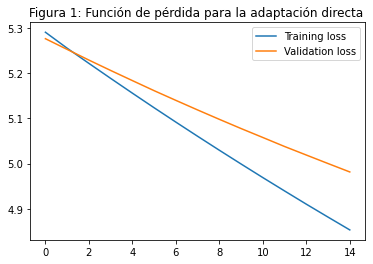

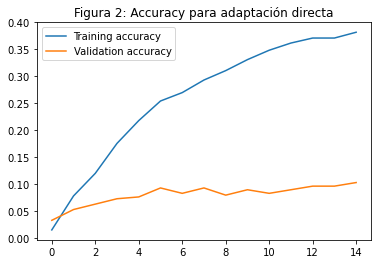

In [3]:
# Recordemos que con anterioridad se han congelado todas las capas
# creamos el modelo Fully Conected de una capa
add_una_capa_con_FC = modelo_resnet50_con_FC.output 
add_una_capa_con_FC = Dense(NUM_CLASES, input_shape = (NUM_CLASES_RESNET,) ,activation = "softmax") (add_una_capa_con_FC)

# Se construye el nuevo modelo
modelo_una_capa_con_FC = tf.keras.models.Model(inputs = modelo_resnet50_con_FC.input, outputs = add_una_capa_con_FC)
CompilarModelo(modelo_una_capa_con_FC)
# entrenamos el modelo
evolucion = modelo_una_capa_con_FC.fit(x_train, y_train, epochs = 15, batch_size = tam_batch, validation_data=(x_validation, y_validation), verbose=1)
#evolucion = modelo_una_capa_con_FC.fit(caracteristicas_train_con_FC, y_train, epochs = epocas, batch_size = tam_batch, validation_data = (caracteristicas_validation_con_FC, y_validation), verbose = 1)
mostrarEvolucion(evolucion, 'Figura 1: Función de pérdida para la adaptación directa ', 'Figura 2: Accuracy para adaptación directa')

Los resultados obtenidos han sido: 
`13s 162ms/step - loss: 4.8535 - accuracy: 0.3819 - val_loss: 4.9816 - val_accuracy: 0.1033`
que son bastante malos. 

*La figura 1* apunta a que el modelo mejoraría con más épocas, pero si tenemos en cuenta el coste computacional y el crecimiento asintótico acotado y lento mostrado en la *figura 2* no creemos que merezca la pena.

Puede además observarse que es posible reducir el costo computacional ya hemos extraído con anterioridad el vector de características, de las imágenes de entrenamiento, validación y test. Es por ello que nos ahorraremos en cómputos anteriores el recalcularlos. Para ello las entradas del modelos serán tales vectores de características en vez de las imágenes originales. 

Si quisiéramos entender un poco el motivo de estos bajos resultados, podría pensarse que con una **adaptación directa sin quitar últimas capas** la red clasifica primero objetos generales, la mayoría de los resultados serán *pájaro*, *gallina* o si predomina el fondo en la imagen algún tipo de vegetación. Luego, con la nueva capa FC añadida, con este vector de 1000 características se intentar clasificar una especie concreta de pájaro.
Aún así el resultado en validación es ligeramente mejor que el esperado por azar 0.005, lo cual es indicativo de que se llega a aprender algún patrón. 


## Estudio 2  

Volveremos a repetir el experimento, con la misma capa final pero con la mejora en coste computacional explicada: 

Model: "con_FC_con_una_capa_reentrenada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 200)               200200    
                                                                 
Total params: 200,200
Trainable params: 200,200
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/35
13/82 [===>..........................] - ETA: 0s - loss: 5.2960 - accuracy: 0.0117  

2021-12-23 12:30:33.486968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 10ms/step - loss: 5.2970 - accuracy: 0.0089 - val_loss: 5.2994 - val_accuracy: 0.0067
Epoch 2/35
 8/82 [=>............................] - ETA: 0s - loss: 5.2995 - accuracy: 0.0000e+00

2021-12-23 12:30:34.229484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 5.2962 - accuracy: 0.0107 - val_loss: 5.2988 - val_accuracy: 0.0067
Epoch 3/35
82/82 [==============================] - 1s 9ms/step - loss: 5.2955 - accuracy: 0.0126 - val_loss: 5.2982 - val_accuracy: 0.0033
Epoch 4/35
82/82 [==============================] - 1s 8ms/step - loss: 5.2948 - accuracy: 0.0130 - val_loss: 5.2976 - val_accuracy: 0.0033
Epoch 5/35
82/82 [==============================] - 1s 8ms/step - loss: 5.2940 - accuracy: 0.0189 - val_loss: 5.2971 - val_accuracy: 0.0100
Epoch 6/35
82/82 [==============================] - 1s 8ms/step - loss: 5.2933 - accuracy: 0.0259 - val_loss: 5.2965 - val_accuracy: 0.0100
Epoch 7/35
82/82 [==============================] - 1s 9ms/step - loss: 5.2925 - accuracy: 0.0263 - val_loss: 5.2959 - val_accuracy: 0.0100
Epoch 8/35
82/82 [==============================] - 1s 9ms/step - loss: 5.2918 - accuracy: 0.0307 - val_loss: 5.2954 - val_accuracy: 0.0133
Epoch 9/35
82/82 [=============

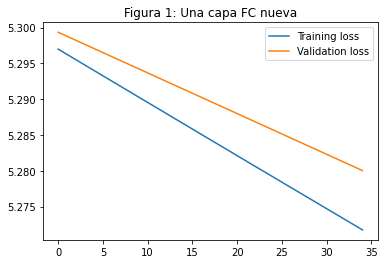

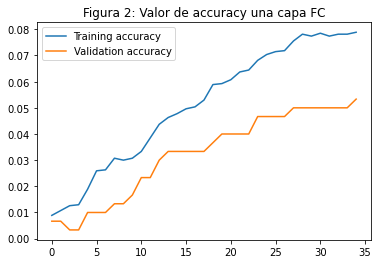

In [10]:
# ______ Primera implementación: Añadimos una sola capa totalmente conectada ___

# Las características extraídas en el paso anterior van a ser la entrada
# de un pequeño modelo de dos capas Fully Conected, donde la última será la que
# nos clasifique las clases de Caltech-UCSD (200 clases). De esta forma, es
# como si hubiéramos fijado todos los parámetros de ResNet50 y estuviésemos
# entrenando únicamente las capas añadidas. Definir dicho modelo.
# A completar: definición del modelo, del optimizador y compilación y
# entrenamiento del modelo.
# En la función fit() puedes usar el argumento validation_split

# creamos el modelo Fully Conected de una capa
modelo_una_capa_con_FC = Sequential(name='con_FC_con_una_capa')
modelo_una_capa_con_FC.add(Dense(NUM_CLASES, input_shape = (1000,) ,activation = "softmax"))
# compilamos el modelo
print(modelo_una_capa_con_FC.summary())

modelo_una_capa_con_FC.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])
# mostramos el resultado

# guardamos los pesos iniciales por si reentrenamos
pesos_iniciales_una_FC = modelo_una_capa_con_FC.get_weights()
# entrenamos el modelo
evolucion = modelo_una_capa_con_FC.fit(caracteristicas_train_con_FC, y_train, epochs = 35, batch_size = tam_batch, validation_data = (caracteristicas_validation_con_FC, y_validation), verbose = 1)
mostrarEvolucion(evolucion, 'Figura 3: Función de pérdida sin eliminar FC de ResNet50', 'Figura 4: Valor de accuracy sin eliminar FC ResNet')

## Estudio 2 resultados   

Los resultados obtenidos tras 35 épocas son  `8ms/step - loss: 5.2717 - accuracy: 0.0789 - val_loss: 5.2800 - val_accuracy: 0.0533`, 
además observando las *figuras 3 y 5* se observa una tendencia a mejorar, sin embargo también existe un sobreentrenamiento que apunta a acentuarse al aumentar el número de iteraciones. 

Los datos están muy próximos a los conseguidos con un clasificador aleatorio.

## Estudio 3 

Ahora eliminaremos las últimas capas y conectaremos la salida del extractor de características que ya hemos visto en *tabla 0* ahora el tamaño de entrada será de 2048 características.

*Tabla 1* : Arquitectura añadida tras quitar FC
Layer (type) | Output Shape | Param #   
:-: | :-: |:-:  
dense_1 (Dense)    |         (None, 200)           |    409800 

Model: "sin_FC_con_una_capa_reentrenada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 200)               409800    
                                                                 
Total params: 409,800
Trainable params: 409,800
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/35
12/82 [===>..........................] - ETA: 0s - loss: 5.8697 - accuracy: 0.0101  

2021-12-24 11:46:45.679683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 10ms/step - loss: 5.4792 - accuracy: 0.0170 - val_loss: 4.9934 - val_accuracy: 0.0433
Epoch 2/35
 8/82 [=>............................] - ETA: 0s - loss: 4.8175 - accuracy: 0.0682

2021-12-24 11:46:46.442041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 4.6098 - accuracy: 0.0881 - val_loss: 4.4169 - val_accuracy: 0.1400
Epoch 3/35
82/82 [==============================] - 1s 9ms/step - loss: 3.9448 - accuracy: 0.2026 - val_loss: 3.9912 - val_accuracy: 0.1900
Epoch 4/35
82/82 [==============================] - 1s 9ms/step - loss: 3.4130 - accuracy: 0.3244 - val_loss: 3.6451 - val_accuracy: 0.2600
Epoch 5/35
82/82 [==============================] - 1s 9ms/step - loss: 2.9847 - accuracy: 0.4304 - val_loss: 3.3814 - val_accuracy: 0.3333
Epoch 6/35
82/82 [==============================] - 1s 9ms/step - loss: 2.6318 - accuracy: 0.5211 - val_loss: 3.1754 - val_accuracy: 0.3600
Epoch 7/35
82/82 [==============================] - 1s 9ms/step - loss: 2.3421 - accuracy: 0.5996 - val_loss: 3.0123 - val_accuracy: 0.4000
Epoch 8/35
82/82 [==============================] - 1s 9ms/step - loss: 2.1012 - accuracy: 0.6559 - val_loss: 2.8589 - val_accuracy: 0.4033
Epoch 9/35
82/82 [=============

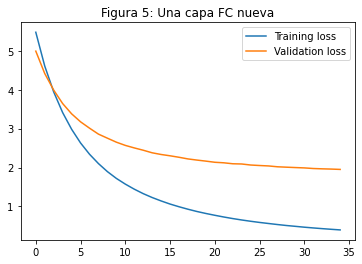

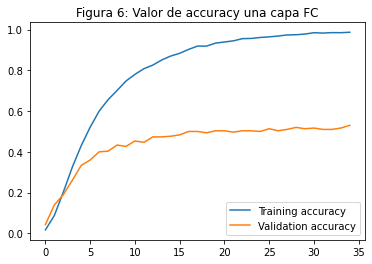

In [59]:
# creamos el modelo Fully Conected de una capa
modelo_una_capa_sin_FC = Sequential(name='sin_FC_con_una_capa_reentrenada')
modelo_una_capa_sin_FC.add(Dense(NUM_CLASES, input_shape = INPUT ,activation = "softmax"))
# compilamos el modelo
print(modelo_una_capa_sin_FC.summary())

modelo_una_capa_sin_FC.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])
# mostramos el resultado

# guardamos los pesos iniciales por si reentrenamos
pesos_iniciales_una_FC = modelo_una_capa_sin_FC.get_weights()
# entrenamos el modelo
evolucion = modelo_una_capa_sin_FC.fit(caracteristicas_train_sin_FC, y_train, epochs = 35, batch_size = tam_batch, validation_data = (caracteristicas_validation_sin_FC, y_validation), verbose = 1)
mostrarEvolucion(evolucion, 'Figura 5: Una capa FC nueva', 'Figura 6: Valor de accuracy una capa FC')

Tras 35 épocas los resultados obtenidos han sido: `9ms/step - loss: 0.3952 - accuracy: 0.9867 - val_loss: 1.9513 - val_accuracy: 0.5300`.

Observando las *figuras 5 y 6* se aprecia una tendencia asintótica en cuanto a mejora y la existencia de un sobreentrenamiento. 
Además de una mejorana notable de los resultados. 

Es por ello que nos planteamos que pensamos los siguiente:
- El entrenamiento de las últimas capas mejora considerablemente la clasificación.
- Es necesario añadir algún sistema para reducir el sobreentrenamiento.
- El hecho de haber reducidido el costo computacional nos permite realizar más épocas del entrenamiento y mejorar los resultados. 

### Estudio 3

Con estas hipótesis diseñamos la siguiente arquitectura que pretende reducir el sobreentrenamiento usando un `Dropout`.   

*Tabla 2* : Arquitectura añadida tras quitar FC y añadir dos capas y dropout
Layer (type) | Output Shape | Param #   
:-: | :-: |:-:  
dense_83 (Dense) | (None, 2048) | 4196352                                                                  
 dropout_80 (Dropout) | None, 2048) | 0         
 dense_84 (Dense) | (None, 200) | 409800    

Model: "Dos_capas_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_80 (Dropout)        (None, 2048)              0         
                                                                 
 dense_84 (Dense)            (None, 200)               409800    
                                                                 
Total params: 4,606,152
Trainable params: 4,606,152
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/35
11/82 [===>..........................] - ETA: 0s - loss: 5.8554 - accuracy: 0.0083   

2021-12-24 11:51:08.322690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 12ms/step - loss: 5.4318 - accuracy: 0.0174 - val_loss: 4.7621 - val_accuracy: 0.0733
Epoch 2/35
 7/82 [=>............................] - ETA: 0s - loss: 4.8343 - accuracy: 0.0649

2021-12-24 11:51:09.237687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 10ms/step - loss: 4.5645 - accuracy: 0.0852 - val_loss: 4.2773 - val_accuracy: 0.1867
Epoch 3/35
82/82 [==============================] - 1s 10ms/step - loss: 3.9273 - accuracy: 0.2000 - val_loss: 3.8153 - val_accuracy: 0.2667
Epoch 4/35
82/82 [==============================] - 1s 10ms/step - loss: 3.3794 - accuracy: 0.2789 - val_loss: 3.4284 - val_accuracy: 0.3067
Epoch 5/35
82/82 [==============================] - 1s 10ms/step - loss: 2.9060 - accuracy: 0.3748 - val_loss: 3.1271 - val_accuracy: 0.3667
Epoch 6/35
82/82 [==============================] - 1s 10ms/step - loss: 2.4885 - accuracy: 0.4604 - val_loss: 2.8752 - val_accuracy: 0.3800
Epoch 7/35
82/82 [==============================] - 1s 10ms/step - loss: 2.1760 - accuracy: 0.5219 - val_loss: 2.7042 - val_accuracy: 0.4167
Epoch 8/35
82/82 [==============================] - 1s 10ms/step - loss: 1.9358 - accuracy: 0.5800 - val_loss: 2.5386 - val_accuracy: 0.4367
Epoch 9/35
82/82 [======

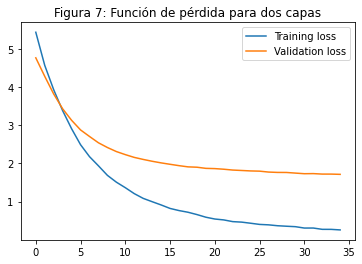

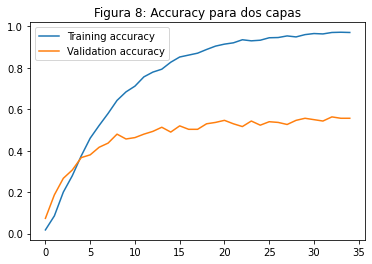

In [60]:
# creamos el modelo Fully Conected de dos capas
modelo_dos_capas_FC = Sequential(name ='Dos_capas_FC')
modelo_dos_capas_FC.add(Dense(NUMERO_CARACTERISTICAS, activation = "relu", input_shape = INPUT))
modelo_dos_capas_FC.add(Dropout(0.5))
modelo_dos_capas_FC.add(Dense(NUM_CLASES, activation = "softmax"))

# compilamos el modelo
modelo_dos_capas_FC.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])

# mostramos el resultado
print(modelo_dos_capas_FC.summary())

# entrenamos el modelo
evolucion = modelo_dos_capas_FC.fit(caracteristicas_train_sin_FC, y_train, epochs = 35, batch_size = tam_batch, validation_data=(caracteristicas_validation_sin_FC, y_validation), verbose = 1)
# mostramos resultados del entrenamiento 
mostrarEvolucion(evolucion, 'Figura 7: Función de pérdida para dos capas', 'Figura 8: Accuracy para dos capas')


### Conclusiones estudio 3

Podemos apreciar que los resultados han mejora un poco tras 35 épocas de entrenamiento.
Se ha mejorado  el accuracy de validación y el sobreentrenamiento (ya que la diferencia entre el accuracy de entrenamiento y validación ha disminuido).

Los resultados obtenidos han sido los siguientes: 
`1s 10ms/step - loss: 0.2587 - accuracy: 0.9711 - val_loss: 1.7129 - val_accuracy: 0.5567`. 

# Conclusiones apartado 3A

Recopilamos el accuracy obtenido en los últimos tres experimentos anteriores: 

*Tabla 3*: Recopilación accuracy estudios

Arquitectura | Accuracy en entrenamiento  época 35 | Accuracy en validación época 35 
:-: | :-: | :-: 
Arquitectura 2 | 0.3819 |  0.1033 
Arquitectura 3 | 0.9867| 0.5300 
Arquitectura 4 | 0.9711 | 0.5567    

Como vemos introducir un cambio y regularización en la aquitectura mejora los resultados.

 


# Apartado 3.B

B.-  Eliminar  las  capas de    salida,  FC  y  AveragePooling.  En  este  momento 
tendrá un extractor de características. Añada nuevas capas que mezclen dichas 
características y den una clasificación. Entrene la red resultante y compare sus 
resultados con los resultados del punto.A 


Para mezclar las capas es necesario el uso de capas de convolución. 


Extraemos las características iniciales, con las propiedades que se piden: 

In [61]:
# con esto conseguimos el modelo sin la ultima capa de pooling
modelo_resnet50_sin_av_pooling = ResNet50(include_top = False, weights = "imagenet", pooling = None)
# Extraer las características las imágenes con el modelo anterior.
# extraemos las de entrenamiento
caracteristicas_train_b = modelo_resnet50_sin_av_pooling.predict_generator(generador_datos_resnet50.flow(x_train_y_validacion, batch_size = 1, shuffle = False), steps = len(x_train_y_validacion), verbose = 1)
# extraemos las caracteristicas de test
caracteristicas_test_b = modelo_resnet50_sin_av_pooling.predict_generator(generador_datos_resnet50.flow(x_test, batch_size = 1, shuffle = False), steps = len(x_test), verbose = 1)

shape = caracteristicas_train_b.shape[1:]

/var/folders/6x/92l244517zjbjbndy62lk_9m0000gn/T/ipykernel_703/4287462569.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  caracteristicas_train_b = modelo_resnet50_sin_av_pooling.predict_generator(generador_datos_resnet50.flow(x_train_y_validacion, batch_size = 1, shuffle = False), steps = len(x_train_y_validacion), verbose = 1)
2021-12-24 13:05:28.881047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  12/3033 [..............................] - ETA: 30s

/var/folders/6x/92l244517zjbjbndy62lk_9m0000gn/T/ipykernel_703/4287462569.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  caracteristicas_test_b = modelo_resnet50_sin_av_pooling.predict_generator(generador_datos_resnet50.flow(x_test, batch_size = 1, shuffle = False), steps = len(x_test), verbose = 1)


3033/3033 [==============================] - 31s 10ms/step


# Estudio 5    

Comenzaremos con un estudio preliminar replicando la estructura de la ResNet y entrenándola. 
Esto es, añadimos las siguientes capas: 

*Tabla 4* : Arquitectura añadida tras quitar FC y pooling y añadir tres convoluciones   

Layer (type) | Output Shape | Param #   
:-: | :-: |:-:  
conv2d_85 (Conv2D)  | (None, 5, 5, 512)    |  9437696                                                              
conv2d_86 (Conv2D)     |      (None, 3, 3, 512)     |    2359808                                                 
conv2d_87 (Conv2D)      |    (None, 1, 1, 512)       |  2359808                                                 
global_average_pooling2d_27 | (None, 512)          |    0         
dense_85 (Dense)      |      (None, 2048)        |      1050624                                                                    
dropout_81 (Dropout)    |    (None, 2048)      |        0                                                                      
 dense_86 (Dense)       |     (None, 200)        |       409800    
                                                                 


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 5, 5, 512)         9437696   
                                                                 
 conv2d_86 (Conv2D)          (None, 3, 3, 512)         2359808   
                                                                 
 conv2d_87 (Conv2D)          (None, 1, 1, 512)         2359808   
                                                                 
 global_average_pooling2d_27  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_85 (Dense)            (None, 2048)              1050624   
                                                                 
 dropout_81 (Dropout)        (None, 2048)              0         
                                                     

2021-12-24 13:07:42.245378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 19893236248084480.0000 - accuracy: 0.0026

2021-12-24 13:07:46.185120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 4s 50ms/step - loss: 19893236248084480.0000 - accuracy: 0.0026 - val_loss: 5.2985 - val_accuracy: 0.0000e+00
Epoch 2/15
82/82 [==============================] - 4s 46ms/step - loss: 5.2984 - accuracy: 0.0015 - val_loss: 5.2987 - val_accuracy: 0.0000e+00
Epoch 3/15
82/82 [==============================] - 4s 45ms/step - loss: 5.2984 - accuracy: 0.0019 - val_loss: 5.2990 - val_accuracy: 0.0000e+00
Epoch 4/15
82/82 [==============================] - 4s 46ms/step - loss: 5.2984 - accuracy: 0.0015 - val_loss: 5.2992 - val_accuracy: 0.0000e+00
Epoch 5/15
82/82 [==============================] - 4s 45ms/step - loss: 5.2984 - accuracy: 0.0037 - val_loss: 5.2995 - val_accuracy: 0.0000e+00
Epoch 6/15
82/82 [==============================] - 4s 45ms/step - loss: 5.2983 - accuracy: 0.0026 - val_loss: 5.2997 - val_accuracy: 0.0000e+00
Epoch 7/15
82/82 [==============================] - 4s 46ms/step - loss: 5.2983 - accuracy: 0.0022 - val_loss: 5.2999 - val_a

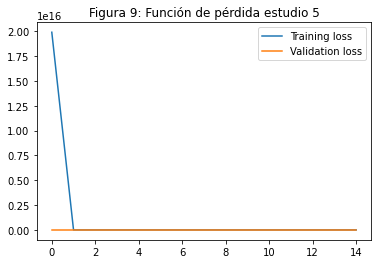

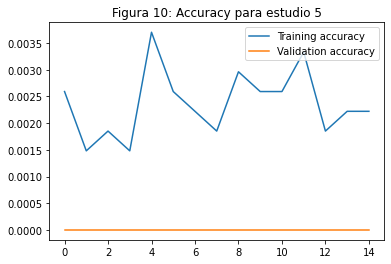

In [62]:
# Arquitectura primera
nuevo_modelo = Sequential()
nuevo_modelo.add( Conv2D(512, kernel_size = (3,3), padding = "valid" , input_shape = shape ) )
nuevo_modelo.add( Conv2D(512, kernel_size = (3,3), padding = "valid") )
nuevo_modelo.add( Conv2D(512, kernel_size = (3,3), padding = "valid") )
nuevo_modelo.add(GlobalAveragePooling2D())
nuevo_modelo.add(Dense(2048, activation = "relu"))
nuevo_modelo.add(Dropout(0.4) )
nuevo_modelo.add(Dense(200, activation = "softmax"))
# Compilado 
nuevo_modelo.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])
# mostrar resumen, ajuste y evolución 
print(nuevo_modelo.summary())
evolucion_b = nuevo_modelo.fit(caracteristicas_train_b, y_train_y_validacion, epochs = 15, batch_size = tam_batch, validation_split = porcentaje_val, verbose = 1)
mostrarEvolucion(evolucion_b, 'Figura 9: Función de pérdida estudio 5', 'Figura 10: Accuracy para estudio 5')

#### Conclusiones estudio 5
Imitar la estructura del ResNet-50 no ha sido una arquitectura, el accuracy prácticamente nulo, concretemante de `46ms/step - loss: 5.2981 - accuracy: 0.0019 - val_loss: 5.3019 - val_accuracy: 0.0000e+00` en la época 15  y su mejora se produce muy lentamente *figura 9 y 10*  
Esto puede deberse a que fue entrenada con una base de datos muchísimo mayor y con más potencia de cómputo. Se han consultado estos datos en la página oficial de keras [3].

### Estudio 6

A la vista de las conclusiones del estudio 5, optaremos por introducir solo una capa de convolución y a partir de los resultados refinar su arquitectura. 

*Tabla 5* Arquitectura estudio 6

Layer (type) | Output Shape | Param #   
:-: | :-: |:-:  
 conv2d_34 (Conv2D)    |      (None, 5, 5, 512)      |   9437696                                                                
 GlobalAveragePooling2D| (None, 512)      |        0                                                                        
 dropout_22 (Dropout)   |     (None, 512)       |        0                                                                        
 dense_23 (Dense)    |        (None, 200)       |        102600  

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 5, 5, 512)         9437696   
                                                                 
 global_average_pooling2d_29  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_89 (Dense)            (None, 2048)              1050624   
                                                                 
 dropout_83 (Dropout)        (None, 2048)              0         
                                                                 
 dense_90 (Dense)            (None, 200)               409800    
                                                                 
Total params: 10,898,120
Trainable params: 10,898,120
Non-trainable params: 0
_________________________________________

2021-12-24 13:16:43.309646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/82 [============================>.] - ETA: 0s - loss: 5.0698 - accuracy: 0.0587

2021-12-24 13:16:45.707895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 3s 32ms/step - loss: 5.0531 - accuracy: 0.0611 - val_loss: 4.1014 - val_accuracy: 0.1200
Epoch 2/25
82/82 [==============================] - 2s 30ms/step - loss: 3.1173 - accuracy: 0.2737 - val_loss: 3.1248 - val_accuracy: 0.2467
Epoch 3/25
82/82 [==============================] - 2s 30ms/step - loss: 2.0260 - accuracy: 0.4763 - val_loss: 2.8450 - val_accuracy: 0.3267
Epoch 4/25
82/82 [==============================] - 2s 29ms/step - loss: 1.3576 - accuracy: 0.6326 - val_loss: 2.5389 - val_accuracy: 0.3600
Epoch 5/25
82/82 [==============================] - 2s 30ms/step - loss: 0.9340 - accuracy: 0.7504 - val_loss: 2.4280 - val_accuracy: 0.4100
Epoch 6/25
82/82 [==============================] - 2s 29ms/step - loss: 0.6326 - accuracy: 0.8330 - val_loss: 2.4134 - val_accuracy: 0.3733
Epoch 7/25
82/82 [==============================] - 2s 29ms/step - loss: 0.4610 - accuracy: 0.8870 - val_loss: 2.3093 - val_accuracy: 0.4433
Epoch 8/25
82/82 [======

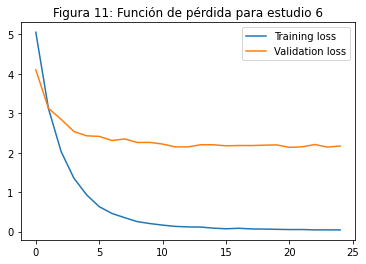

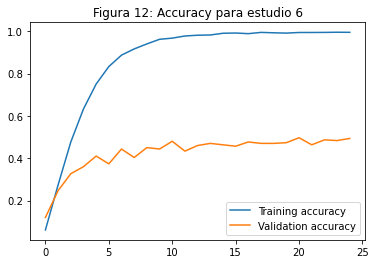

In [64]:
# Arquitectura estudio 6
nuevo_modelo = Sequential()
nuevo_modelo.add( Conv2D(512, kernel_size = (3,3), padding = "valid" , input_shape = forma ) )
nuevo_modelo.add(GlobalAveragePooling2D())
nuevo_modelo.add(Dense(2048, activation = "relu"))
nuevo_modelo.add(Dropout(0.4) )
nuevo_modelo.add(Dense(200, activation = "softmax"))
# Compilado 
nuevo_modelo.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])
# mostrar resumen, ajuste y evolución 
print(nuevo_modelo.summary())
evolucion_b = nuevo_modelo.fit(caracteristicas_train_b, y_train_y_validacion, epochs = 25, batch_size = tam_batch, validation_split = porcentaje_val, verbose = 1)
mostrarEvolucion(evolucion_b, 'Figura 11: Función de pérdida para estudio 6', 'Figura 12: Accuracy para estudio 6')

### Conclusiones estudio 6 

 Los resultados obtenidos en la época 25º son ` 30ms/step - loss: 0.0430 - accuracy: 0.9948 - val_loss: 2.1699 - val_accuracy: 0.4933` y por la tendencia observada en las *figuras 11 y 12* no parece que los resultados vayan a mejorar considerablemente. 

Ante esta situación nuestra postura es la siguiente: 
Es necesario modificar la ResNet50 para adaptarla a nuestros datos como vimos en *conclusiones 3A* , aunque el cuánto y cómo modificarla es algo que todavía no está claro. Modificaciones sencillas como hacíamos en los *estudios 3 y 4* condujeron  a mejoras considerables, que nos hacían pensar que cambios más notables mejorarían más aún los resultados. 

Como con el *estudio 6* no hemos conseguido eso entendemos que el problema reside en los ajustes tomados y procedemos a refinarlos observando que se puede apreciar un claro sobreentrenamiento por el valor del accuracy y del valor del accuracy, así como en el comportamiento asintótico *Figuras 11 y 12* .
Además si comparamos a nivel de épocas el resultado es mejor que en los estudios anteriores. 

## Estudio 7   

Tras esto es por ello que para arreglar el sobreentrenamiento proponemos la siguiente arquitectura

*Tabla 6* Arquitectura estudio 7

Layer (type) | Output Shape | Param #   
:-: | :-: |:-:  
 conv2d_90 (Conv2D)        |  (None, 5, 5, 512)     |    9437696   
 dropout_84 (Dropout)    |    (None, 5, 5, 512)    |     0         
 batch_normalization_31  |  (None, 5, 5, 512)     |   2048                                            
 conv2d_91 (Conv2D)      |    (None, 3, 3, 512)   |      2359808                                                   
 global_average_pooling2d_30 | (None, 512)         |     0         
 dense_91 (Dense)        |    (None, 2048)         |     1050624   
 dropout_85 (Dropout)     |   (None, 2048)        |      0         
 dense_92 (Dense)         |   (None, 200)         |      409800    

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 5, 5, 512)         9437696   
                                                                 
 dropout_84 (Dropout)        (None, 5, 5, 512)         0         
                                                                 
 batch_normalization_31 (Bat  (None, 5, 5, 512)        2048      
 chNormalization)                                                
                                                                 
 conv2d_91 (Conv2D)          (None, 3, 3, 512)         2359808   
                                                                 
 global_average_pooling2d_30  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_91 (Dense)            (None, 2048)            

2021-12-24 13:31:10.837590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/82 [============================>.] - ETA: 0s - loss: 4.9945 - accuracy: 0.0453

2021-12-24 13:31:14.070886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 4s 41ms/step - loss: 4.9909 - accuracy: 0.0452 - val_loss: 4.3673 - val_accuracy: 0.1067
Epoch 2/15
82/82 [==============================] - 3s 39ms/step - loss: 3.6764 - accuracy: 0.2430 - val_loss: 3.5355 - val_accuracy: 0.1700
Epoch 3/15
82/82 [==============================] - 3s 39ms/step - loss: 2.6741 - accuracy: 0.4148 - val_loss: 2.9731 - val_accuracy: 0.3133
Epoch 4/15
82/82 [==============================] - 3s 38ms/step - loss: 1.9382 - accuracy: 0.5785 - val_loss: 2.7003 - val_accuracy: 0.3200
Epoch 5/15
82/82 [==============================] - 3s 38ms/step - loss: 1.5047 - accuracy: 0.6770 - val_loss: 2.4581 - val_accuracy: 0.3500
Epoch 6/15
82/82 [==============================] - 3s 38ms/step - loss: 1.1336 - accuracy: 0.7626 - val_loss: 2.3622 - val_accuracy: 0.4133
Epoch 7/15
82/82 [==============================] - 3s 38ms/step - loss: 0.8897 - accuracy: 0.8119 - val_loss: 2.2996 - val_accuracy: 0.4100
Epoch 8/15
82/82 [======

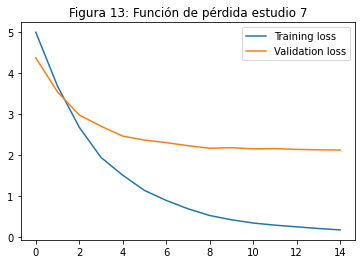

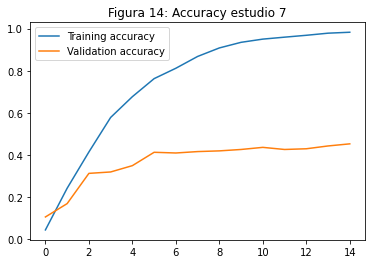

In [65]:

nuevo_modelo = Sequential()
nuevo_modelo.add( Conv2D(512, kernel_size = (3,3), padding = "valid", input_shape = shape ) )
nuevo_modelo.add(Dropout(0.2) )
nuevo_modelo.add(BatchNormalization())
nuevo_modelo.add( Conv2D(512, kernel_size = (3,3), padding = "valid" ) )
nuevo_modelo.add(GlobalAveragePooling2D())
nuevo_modelo.add(Dense(2048, activation = "relu"))
nuevo_modelo.add(Dropout(0.5) )
nuevo_modelo.add(Dense(200, activation = "softmax"))
# Compilado 
nuevo_modelo.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])
# mostrar resumen, ajuste y evolución 
print(nuevo_modelo.summary())
evolucion_b = nuevo_modelo.fit(caracteristicas_train_b, y_train_y_validacion, epochs = 15, batch_size = tam_batch, validation_split = porcentaje_val, verbose = 1)
mostrarEvolucion(evolucion_b, 'Figura 13: Función de pérdida estudio 7', 'Figura 14: Accuracy estudio 7')

### Conclusión  estudio 7  

Los resultados tras la época 15º son `loss: 0.1709 - accuracy: 0.9826 - val_loss: 2.1189 - val_accuracy: 0.4533`, mejores que el estudio anterior. 

Sigue existiendo demasiado sobre entrenamiento y las *figuras 13 y 14* apuntan a que más épocas no mejorarían considerablemente el accuracy de validación .
Necesitamos por tanto afrontar los cambios desde otra perspectiva, quizás probando con un ajuste fino. 


##  Apartado 2. Ajuste fino 

Para comprender mejor de que se trata el ajuste fino hemos consultado la página oficia de keras [5]. 

En este apartado lo que queremos hacer es similar a lo que hicimos en el anterior, pero en vez de extraer características de las imágenes usando Resnet50 y construir un modelo posterior, consideramos todo como un único modelo que entrenaremos completamente unas pocas épocas. Aprovechamos que la red ya está preentrenada y tendrá unos pesos bastante buenos, y al entrenarla entera movemos un poco estos pesos para adaptarnos a nuestro problema concreto.

Nos basaremos además en la *arquitectura 4* del estudio 4 que era la que presentaba mejores resultados. 

### Estudio 8 
Entrenaremos todo el modelo 10 épocas. 

Epoch 1/10


2021-12-24 17:23:26.098704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 5.4341 - accuracy: 0.0304

2021-12-24 17:23:39.423609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 16s 182ms/step - loss: 5.4341 - accuracy: 0.0304 - val_loss: 4.3474 - val_accuracy: 0.1367
Epoch 2/10
82/82 [==============================] - 14s 170ms/step - loss: 3.8987 - accuracy: 0.1526 - val_loss: 3.4963 - val_accuracy: 0.2667
Epoch 3/10
82/82 [==============================] - 14s 170ms/step - loss: 3.0528 - accuracy: 0.2752 - val_loss: 3.0569 - val_accuracy: 0.2667
Epoch 4/10
82/82 [==============================] - 14s 171ms/step - loss: 2.4250 - accuracy: 0.3844 - val_loss: 2.8281 - val_accuracy: 0.3167
Epoch 5/10
82/82 [==============================] - 14s 171ms/step - loss: 1.9687 - accuracy: 0.4837 - val_loss: 2.7450 - val_accuracy: 0.3367
Epoch 6/10
82/82 [==============================] - 14s 169ms/step - loss: 1.6123 - accuracy: 0.5752 - val_loss: 2.5480 - val_accuracy: 0.3500
Epoch 7/10
82/82 [==============================] - 14s 169ms/step - loss: 1.3109 - accuracy: 0.6344 - val_loss: 2.5323 - val_accuracy: 0.3767
Epoch 8/10

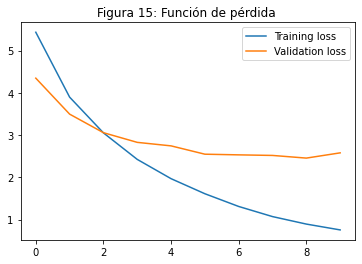

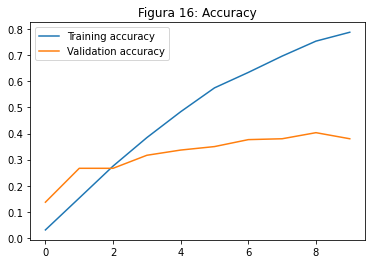

In [6]:
# Entrenamos ligeramente solo la última capa para conseguir el accuracy que teniamos 
modelo_resnet50 = ResNet50(
include_top = False, # No incluimos la capa FC, ya que queremos entrenarla
weights = "imagenet", # pesos entrenados de imagenenet
pooling = "avg",
input_shape = (224, 224, 3))

modelo_resnet50.trainable = False
ajuste_fino = modelo_resnet50.output 

CAPAS = [
    Dense(NUMERO_CARACTERISTICAS, activation = "relu"),
    Dropout(0.5),
    Dense(200, activation = 'softmax')
]
for capa in CAPAS:
    ajuste_fino= capa (ajuste_fino)

# Se construye el nuevo modelo
modelo_fino = tf.keras.models.Model(inputs = modelo_resnet50.input, outputs = ajuste_fino )
CompilarModelo(modelo_fino)
# entrenamos el modelo
evolucion = modelo_fino.fit(x_train, y_train, epochs = 10, batch_size = tam_batch, validation_data=(x_validation, y_validation), verbose=1)

#evolucion = modelo_una_capa_con_FC.fit(caracteristicas_train_con_FC, y_train, epochs = epocas, batch_size = tam_batch, validation_data = (caracteristicas_validation_con_FC, y_validation), verbose = 1)
mostrarEvolucion(evolucion, 'Figura 15: Función de pérdida ', 'Figura 16: Accuracy')

Epoch 1/15


2021-12-24 17:41:03.834824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 4.1872 - accuracy: 0.0978

2021-12-24 17:41:49.198070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 49s 561ms/step - loss: 4.1872 - accuracy: 0.0978 - val_loss: 45.4875 - val_accuracy: 0.0033
Epoch 2/15
82/82 [==============================] - 45s 547ms/step - loss: 3.2477 - accuracy: 0.2070 - val_loss: 11.2601 - val_accuracy: 0.0367
Epoch 3/15
82/82 [==============================] - 43s 530ms/step - loss: 2.5644 - accuracy: 0.3363 - val_loss: 8.4846 - val_accuracy: 0.0667
Epoch 4/15
82/82 [==============================] - 43s 525ms/step - loss: 1.9645 - accuracy: 0.4611 - val_loss: 5.8398 - val_accuracy: 0.0467
Epoch 5/15
82/82 [==============================] - 43s 527ms/step - loss: 1.5109 - accuracy: 0.5600 - val_loss: 4.9403 - val_accuracy: 0.1267
Epoch 6/15
82/82 [==============================] - 43s 525ms/step - loss: 1.1372 - accuracy: 0.6504 - val_loss: 5.4814 - val_accuracy: 0.1300
Epoch 7/15
82/82 [==============================] - 43s 526ms/step - loss: 0.8739 - accuracy: 0.7378 - val_loss: 4.3055 - val_accuracy: 0.2067
Epoch 8/

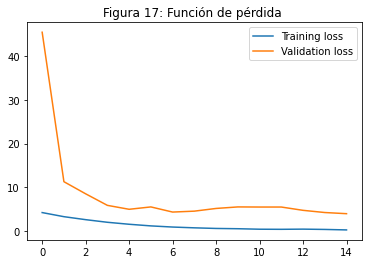

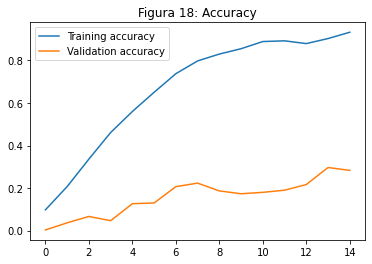

In [11]:
# Entrenamos todo el modelo
modelo_resnet50 = ResNet50(
include_top = False, # No incluimos la capa FC, ya que queremos entrenarla
weights = "imagenet", # pesos entrenados de imagenenet
pooling = "avg",
input_shape = (224, 224, 3))

modelo_resnet50.trainable = True
ajuste_fino2 = modelo_resnet50.output 


CAPAS = [
    Dense(NUMERO_CARACTERISTICAS, activation = "relu"),
    Dropout(0.5),
    Dense(200, activation = 'softmax')
]
for capa in CAPAS:
    ajuste_fino2= capa (ajuste_fino2)

# Se construye el nuevo modelo
modelo_fino2 = tf.keras.models.Model(inputs = modelo_resnet50.input, outputs = ajuste_fino2 )
modelo_fino2.set_weights(modelo_fino.get_weights())
CompilarModelo(modelo_fino2)
# entrenamos el modelo
evolucion = modelo_fino2.fit(x_train, y_train, epochs = 15, batch_size = tam_batch, validation_data=(x_validation, y_validation), verbose=1)

#evolucion = modelo_una_capa_con_FC.fit(caracteristicas_train_con_FC, y_train, epochs = epocas, batch_size = tam_batch, validation_data = (caracteristicas_validation_con_FC, y_validation), verbose = 1)

mostrarEvolucion(evolucion, 'Figura 17: Función de pérdida ', 'Figura 18: Accuracy')

#### Observaciones  

El accuracy en entrenamiento crece más rápido que durante el *estudio 3* (ver logs) pero sin embargo el sobreentrenamiento es mucho más fuerte y el tiempo de cómputo también. 

Esto puede deberse a que tiene demasiados parámetros que entrenar.

### Conclusiones estudio 8
Resultado no ha mejorado los anteriores, no es posible tampoco aumentar demasiado el número de épocas por el excesivo coste computacional.
Es por ello que procedemos a realizar un ajuste fino de las últimas capas mantiendo las primeras intactas. 
La filosofía subyaciente tras esto es que la red Resnet50 fue entendida para clasificación y las primeras capas se encargarán de ello. 

 Es por ello que en vez de entrenar todo el modelo, vamos a entrenar el último tercio de las capas. 

## Estudio 9


Epoch 1/10


2021-12-24 17:58:00.317552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 4.5684 - accuracy: 0.0952

2021-12-24 17:58:38.795520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 43s 468ms/step - loss: 4.5684 - accuracy: 0.0952 - val_loss: 10.8474 - val_accuracy: 0.0367
Epoch 2/10
82/82 [==============================] - 36s 440ms/step - loss: 2.4637 - accuracy: 0.3574 - val_loss: 4.2962 - val_accuracy: 0.2067
Epoch 3/10
82/82 [==============================] - 36s 436ms/step - loss: 1.3641 - accuracy: 0.6159 - val_loss: 3.4856 - val_accuracy: 0.2933
Epoch 4/10
82/82 [==============================] - 36s 435ms/step - loss: 0.6962 - accuracy: 0.7941 - val_loss: 4.2555 - val_accuracy: 0.2633
Epoch 5/10
82/82 [==============================] - 35s 433ms/step - loss: 0.3944 - accuracy: 0.8911 - val_loss: 2.7434 - val_accuracy: 0.3900
Epoch 6/10
82/82 [==============================] - 35s 433ms/step - loss: 0.2213 - accuracy: 0.9411 - val_loss: 3.0260 - val_accuracy: 0.3833
Epoch 7/10
82/82 [==============================] - 36s 437ms/step - loss: 0.1665 - accuracy: 0.9581 - val_loss: 3.0728 - val_accuracy: 0.3900
Epoch 8/1

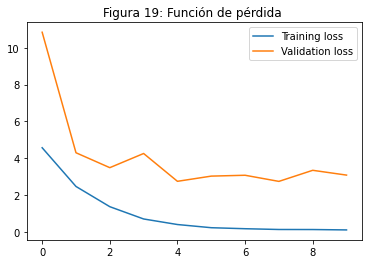

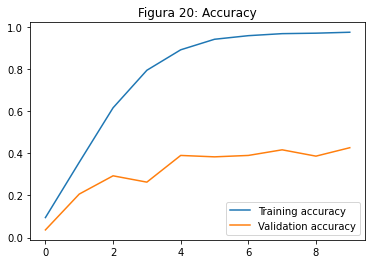

In [14]:
# Entrenamos solo la mitad de las capas 

for layer in modelo_resnet50.layers[:(len(modelo_resnet50.layers)*2)//3]:
    if (not isinstance(layer, keras.layers.BatchNormalization)):
        layer.trainable = False

ajuste_fino3 = modelo_resnet50.output 

CAPAS = [
    Dense(NUMERO_CARACTERISTICAS, activation = "relu"),
    Dropout(0.5),
    Dense(200, activation = 'softmax')
]
for capa in CAPAS:
    ajuste_fino3= capa (ajuste_fino3)

# Se construye el nuevo modelo
modelo_fino3 = tf.keras.models.Model(inputs = modelo_resnet50.input, outputs = ajuste_fino3 )
CompilarModelo(modelo_fino3)
# entrenamos el modelo
evolucion = modelo_fino3.fit(x_train, y_train, epochs = 10, batch_size = tam_batch, validation_data=(x_validation, y_validation), verbose=1)

#evolucion = modelo_una_capa_con_FC.fit(caracteristicas_train_con_FC, y_train, epochs = epocas, batch_size = tam_batch, validation_data = (caracteristicas_validation_con_FC, y_validation), verbose = 1)
mostrarEvolucion(evolucion, 'Figura 19: Función de pérdida ', 'Figura 20: Accuracy')


### Conclusiones estudio 9   

Ahora el accuracy crece muchísimo más rápido y el sobreentrenamiento se ha reducido. Adeás el entrenamiento es mucho más rápido. 

El resultado final ha sido ` 36s 434ms/step - loss: 0.1013 - accuracy: 0.9744 - val_loss: 3.0813 - val_accuracy: 0.4267` comparable con los que no han realizado ajuste fino. 


Epoch 1/15


2021-12-23 12:18:26.724589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 5.4607 - accuracy: 0.0122

2021-12-23 12:18:39.874267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 16s 179ms/step - loss: 5.4607 - accuracy: 0.0122 - val_loss: 4.6850 - val_accuracy: 0.0533
Epoch 2/15
82/82 [==============================] - 14s 168ms/step - loss: 4.5289 - accuracy: 0.0722 - val_loss: 4.2226 - val_accuracy: 0.0900
Epoch 3/15
82/82 [==============================] - 14s 171ms/step - loss: 3.8029 - accuracy: 0.1589 - val_loss: 3.7198 - val_accuracy: 0.1900
Epoch 4/15
82/82 [==============================] - 14s 168ms/step - loss: 3.2400 - accuracy: 0.2415 - val_loss: 3.7754 - val_accuracy: 0.1600
Epoch 5/15
82/82 [==============================] - 14s 169ms/step - loss: 2.7334 - accuracy: 0.3404 - val_loss: 3.9441 - val_accuracy: 0.2000
Epoch 6/15
82/82 [==============================] - 14s 168ms/step - loss: 2.2370 - accuracy: 0.4356 - val_loss: 3.9462 - val_accuracy: 0.2033
Epoch 7/15
82/82 [==============================] - 14s 169ms/step - loss: 1.8167 - accuracy: 0.5156 - val_loss: 4.0357 - val_accuracy: 0.2033
Epoch 8/15

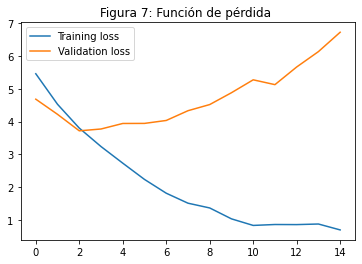

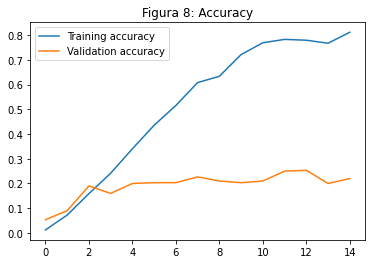

In [6]:
modelo_resnet50 = ResNet50(
  include_top = False, 
  weights = "imagenet", # pesos entrenados de imagenenet
  pooling = None, 
  input_shape = (224, 224, 3))

modelo_resnet50.trainable = False 
apartado3_b_1 = modelo_resnet50.output 

CAPAS = [
    Conv2D(256,kernel_size = (1, 1)),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(128, kernel_size = (3,3)),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(60, kernel_size = (3,3)),
    Flatten(),
    Dense(1024, activation = LeakyReLU()),
    Dropout(0.5),
    Dense(512, activation = LeakyReLU()),
    Dropout(0.5),
    Dense(200, activation = 'softmax')
]
for capa in CAPAS:
    apartado3_b_1 = capa (apartado3_b_1)

# Se construye el nuevo modelo
modelo_apartado3_b_1 = tf.keras.models.Model(inputs = modelo_resnet50.input, outputs = apartado3_b_1 )
CompilarModelo(modelo_apartado3_b_1)
# entrenamos el modelo
evolucion = modelo_apartado3_b_1.fit(x_train, y_train, epochs = 15, batch_size = tam_batch, validation_data=(x_validation, y_validation), verbose=1)
#evolucion = modelo_una_capa_con_FC.fit(caracteristicas_train_con_FC, y_train, epochs = epocas, batch_size = tam_batch, validation_data = (caracteristicas_validation_con_FC, y_validation), verbose = 1)
mostrarEvolucion(evolucion, 'Figura 7: Función de pérdida ', 'Figura 8: Accuracy')

Podemos observar que los resultados no han mejorado notablemente. 

Esto puede deberse a que *número de capas que lo han preprocesado en la resnet 50* han sido demasiadas y habría que optar por un ajuste fino.

## El mejor modelo ha sido el modelo del estudio tercero 

Procedemos a ver sus resultados en test 

In [15]:
# creamos el modelo Fully Conected de dos capas
modelo_dos_capas_FC = Sequential(name ='Dos_capas_FC')
modelo_dos_capas_FC.add(Dense(NUMERO_CARACTERISTICAS, activation = "relu", input_shape = INPUT))
modelo_dos_capas_FC.add(Dropout(0.5))
modelo_dos_capas_FC.add(Dense(NUM_CLASES, activation = "softmax"))

# compilamos el modelo
modelo_dos_capas_FC.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizador, metrics = ["accuracy"])

# mostramos el resultado
print(modelo_dos_capas_FC.summary())

# entrenamos el modelo
evolucion = modelo_dos_capas_FC.fit(caracteristicas_train_sin_FC, y_train, epochs = 35, batch_size = tam_batch, validation_data=(caracteristicas_validation_sin_FC, y_validation), verbose = 1)
prediccion_test = modelo_dos_capas_FC.predict(caracteristicas_test_sin_FC, batch_size = tam_batch, verbose = 1)

# obtenemos el accuracy
accuracy_test = calcularAccuracy(y_test,prediccion_test )

print("El accuracy en test es de: {}".format(accuracy_test))

Model: "Dos_capas_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 200)               409800    
                                                                 
Total params: 4,606,152
Trainable params: 4,606,152
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/35
 5/82 [>.............................] - ETA: 1s - loss: 5.9233 - accuracy: 0.0000e+00 

2021-12-24 18:15:13.192574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 14ms/step - loss: 5.4449 - accuracy: 0.0174 - val_loss: 4.7565 - val_accuracy: 0.1000
Epoch 2/35
 1/82 [..............................] - ETA: 0s - loss: 4.6729 - accuracy: 0.1212

2021-12-24 18:15:14.265637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 12ms/step - loss: 4.5725 - accuracy: 0.0833 - val_loss: 4.2067 - val_accuracy: 0.2267
Epoch 3/35
82/82 [==============================] - 1s 12ms/step - loss: 3.9338 - accuracy: 0.1948 - val_loss: 3.7562 - val_accuracy: 0.2733
Epoch 4/35
82/82 [==============================] - 1s 12ms/step - loss: 3.3755 - accuracy: 0.2937 - val_loss: 3.3640 - val_accuracy: 0.3367
Epoch 5/35
82/82 [==============================] - 1s 12ms/step - loss: 2.9035 - accuracy: 0.3837 - val_loss: 3.0609 - val_accuracy: 0.3400
Epoch 6/35
82/82 [==============================] - 1s 11ms/step - loss: 2.4882 - accuracy: 0.4674 - val_loss: 2.8212 - val_accuracy: 0.4000
Epoch 7/35
82/82 [==============================] - 1s 11ms/step - loss: 2.1483 - accuracy: 0.5537 - val_loss: 2.6230 - val_accuracy: 0.4233
Epoch 8/35
82/82 [==============================] - 1s 11ms/step - loss: 1.9065 - accuracy: 0.5952 - val_loss: 2.4846 - val_accuracy: 0.4167
Epoch 9/35
82/82 [======

2021-12-24 18:15:46.435278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 0s 3ms/step
El accuracy en test es de: 0.43653148697659083


# Resultados en test 

Se ha obtenido con el mejor modelo un accuracy en test de 0.4365 frente al 0.5533 de validación. 


# Conclusiones finales del ejercicio 3  

Se ha partido de una red ResNet con un 0.713 de accuracy en Top-1 y un 0.900 en Top5 en la base de datos de ImagiNet [3], que como sabemos es una red de clasificación de objetos generales [4] y se ha pretendido adaptar para clasificación de aves.  

Con una **adaptación directa sin quitar últimas capas** se ha obtenido un accuracy muy bajo, alrededor del  0.1. Podemos entender que si esta red clasifica objetos generales, la mayoría de los resultados serán *pájaro*, *gallina* o si predomina el fondo en la imagen algún tipo de vegetación, es por ello que intentar clasificar una especie de pájaro tras la clasificación parece complicado. Aún así el resultado es ligeramente mejor que el esperado por azar 0.005, lo cual es indicativo de que se llega a descubrir algún patrón. 

Se produce una mejora considerable de un accuracy en validación del  0.5567    **sustituyendo la última** por dos capas densas. Esto demuestra que utilizar las primeras capas de la una red preentrenada tiene gran valor como estractor de características.   

Posteriormente se intentó añadir más capas capas de convolución lo cuál producía peores resultados y mayor sobreentrenamiento, esto podía producirse porque las características ya estaban muy desvirtuadas o  falta de datos suficientes en el entrenamiento.   

Introdujimos por tanto el ajuste fino que si era sobre todas las capas producía demasiado sobreentrenamiento y malos resultados, manteniendo tan solo el último tercio de las capas se conseguí un resultado similar al utilizado tan solo en extracción de características, eso sí, con un notable incremento del tiempo de cómputo. 

En lo que respecta a otro tipo de conclusiones, el tratar de mejorar la eficiencia computacional, ha sido beneficioso (ver estudios 1 y 3), ya que nos permite aumentar el número de épocas y converger a soluciones mejores. 


Finalmente comentar que el ajuste fino es un arma de doble filo ya que permite llegar a resultados más finos que los obtenidos con extracción de características, pero requiere de mayor esfuerzo conceptual en el ajuste y potencia computacional. 


## Cómo se podría haber ampliado el experimento  

- Aumentar el conjunto de dataset.
- Probar más combinaciones de capas convolucionales y tratar de reducir el sobreentrenamiento. 
- Probar más combinaciones en el ajuste fino de capas que entrenar y cuáles no. 

# Bibliografía y links de interés 

- [1] Título: *ResNet and ResNetV2*. Autor: Página oficial de keras. URL: https://keras.io/api/applications/resnet/#resnet50-function Fecha consulta: 22-12-21
- [2] Título del artículo *Deep Residual Learning for Image Recognition. Autores Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun Fecha de publicación 2005. URL: https://arxiv.org/abs/1512.03385
- [3] Título *Keras applications* Autor: Web oficial de keras. URL: https://keras.io/api/applications/ Fecha de consulta: 24-12-21
- [4] Título *ImageNet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012)* URL: https://image-net.org/challenges/LSVRC/2012/browse-synsets.php Fecha de consulta: 24-12-21
- [5] Título: *Transfer learning*. Autor: Página oficial de keras. URL: https://keras.io/guides/transfer_learning/  Fecha consulta: 24-12-21